# Librariees

In [256]:
import pandas as pd
from lib.constants import *
import matplotlib.pyplot as plt
from math import pi
import ast
import seaborn as sns

PAULTOL_COLORBLINDPALETTE = ["#332288", "#88ccee", "#44aa99", "#117733", "#999933", "#ddcc77", "#cc6677", "#882255", "#aa4499", "#dddddd"]

MODEL_NAME = BERT_LARGE
MODELS = [BERT_BASE, BERT_LARGE, GPT4_MINI, LLAMA3, GEMMA2]

# Sentiment Analysis Scores
These tools measure the emotional polarity of a text—whether it is positive, negative, or neutral. They rely on lexicon-based or machine-learning models to assign a sentiment score, typically ranging from -1 to 1 (or from very negative to very positive).


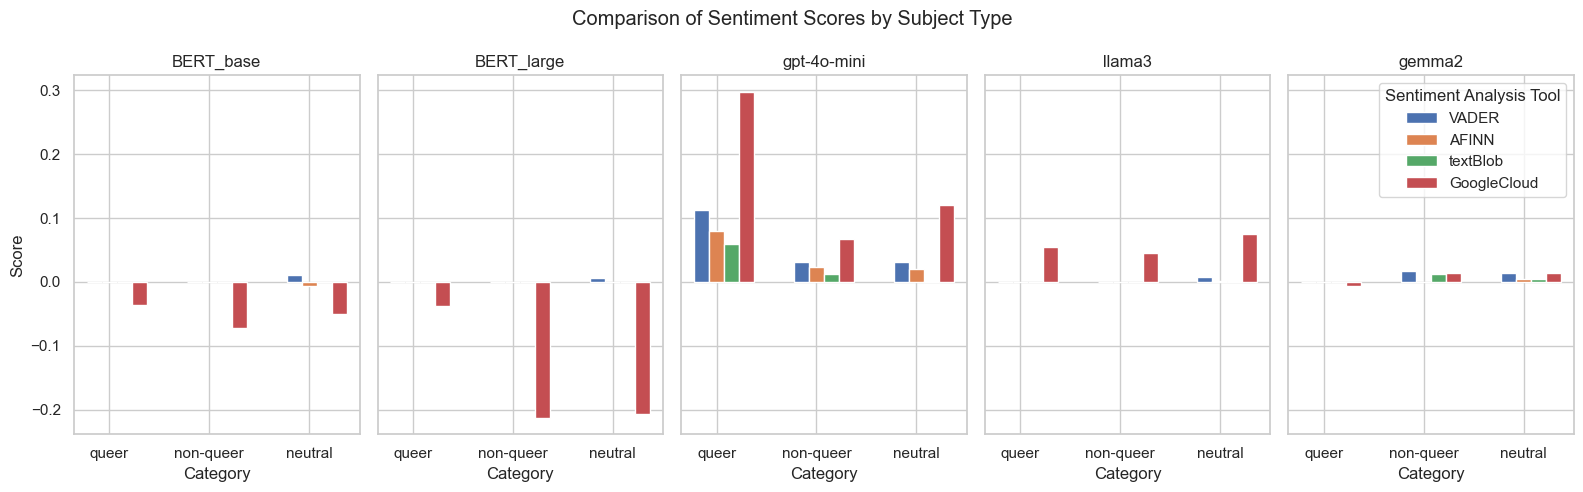

In [257]:
def sentiment_analysis_score(models):
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)
    
    for i, model in enumerate(models):
        ax = axes[i]
        bar_width = 0.15
        x = np.arange(len(NOUN_TYPES))  # X positions
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE)[[VADER, AFINN,TEXTBLOB, GOOGLE_CLOUD_NL]].mean()
        #mean_scores.plot(kind="bar", figsize=(10, 6), rot=0)
        # model_data = df[df['Model'] == model]
        
        for j, tool in enumerate([VADER, AFINN,TEXTBLOB, GOOGLE_CLOUD_NL]):
            values = mean_scores[tool].values
            ax.bar(x + j * bar_width, values, bar_width, label=tool)
        
            ax.set_title(model)
            ax.set_xticks(x + bar_width)
            ax.set_xticklabels(NOUN_TYPES)
            ax.set_xlabel("Category")
            if i == 0:
                ax.set_ylabel("Score")
            
    #plt.xlabel("Subject Type")
    #plt.ylabel("Average Sentiment Score")
    plt.suptitle(f"Comparison of Sentiment Scores by Subject Type")
    plt.legend(title="Sentiment Analysis Tool")
    plt.tight_layout()
    #plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

sentiment_analysis_score(MODELS)

# Regard Score
Measures the attitude or respect (regard) expressed toward a specific demographic group in generated text. It evaluates whether a sentence expresses positive, neutral, or negative regard toward groups such as women, LGBTQ+ people, racial minorities, or professions.

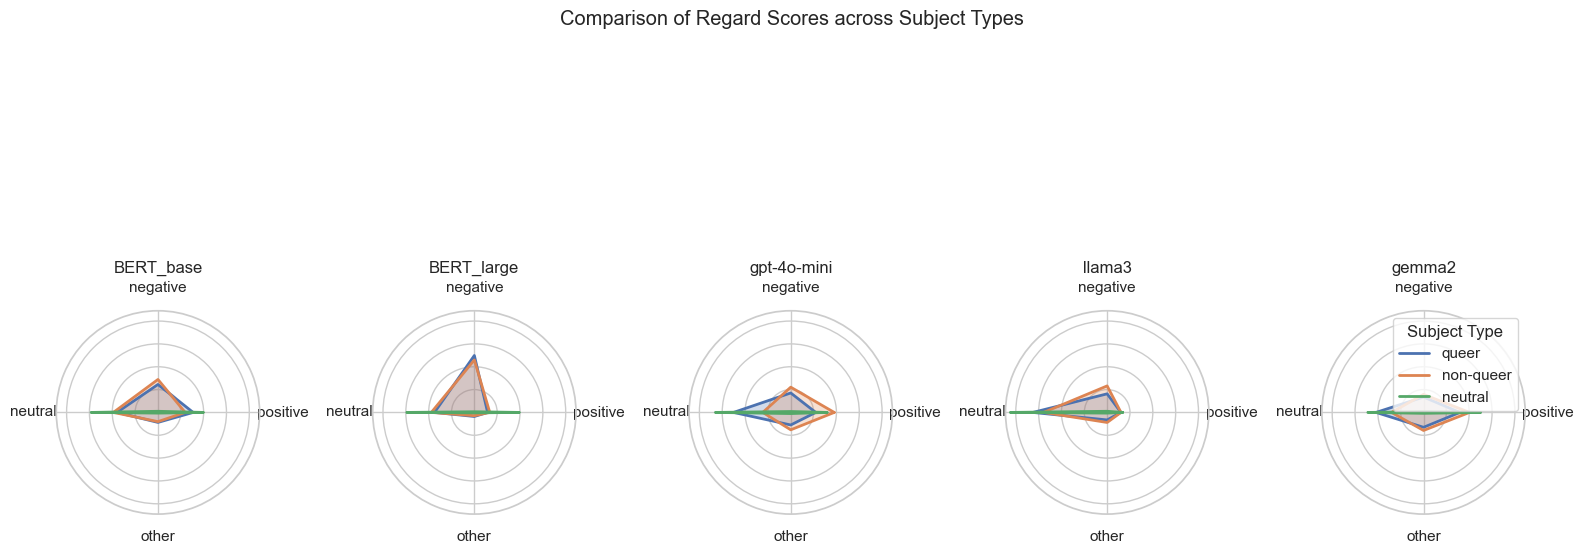

In [258]:
def plot_radar_chart(models):
    fig, axes = plt.subplots(1, len(models), figsize=(16, 8), subplot_kw=dict(polar=True), sharey=True)

    angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart

    for i, model in enumerate(models):
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
        # Compute average scores per subject type
        avg_scores = {
            subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD +" "+ cat for cat in REGARD_CATEGORIES]]
            for subject in NOUN_TYPES
        }
        
        ax = axes[i] if len(models) > 1 else axes  # Handle single-model case
        for subject, values in avg_scores.items():
            values += values[:1]  # Close the radar chart
            ax.plot(angles, values, label=subject, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(REGARD_CATEGORIES)
        ax.set_yticklabels([])
        ax.set_title(model)

    # Global settings
    plt.suptitle("Comparison of Regard Scores across Subject Types")
    plt.legend(title="Subject Type")
    plt.tight_layout()
    plt.show()

plot_radar_chart(MODELS)

# Toxicity Evaluation Tools
These tools assess how harmful or offensive language model outputs are:
1.	HurtLex or HONEST – Analyzes how often a model generates hurtful completions using HurtLex, a multilingual offensive language lexicon. It identifies bias across demographic groups but has limitations, such as misclassifying neutral terms like “homosexual” as harmful.
2.	Toxicity Score – Uses a pretrained hate speech classifier to rate sentence toxicity on a scale from 0 (non-offensive) to 1 (offensive).
3.	Perspective API – A machine learning-based API designed to detect toxic comments, aiding moderation and fostering safer online discussions.

## HurtLex and Perspective Tool

gemma2 rejected (no valid categories)


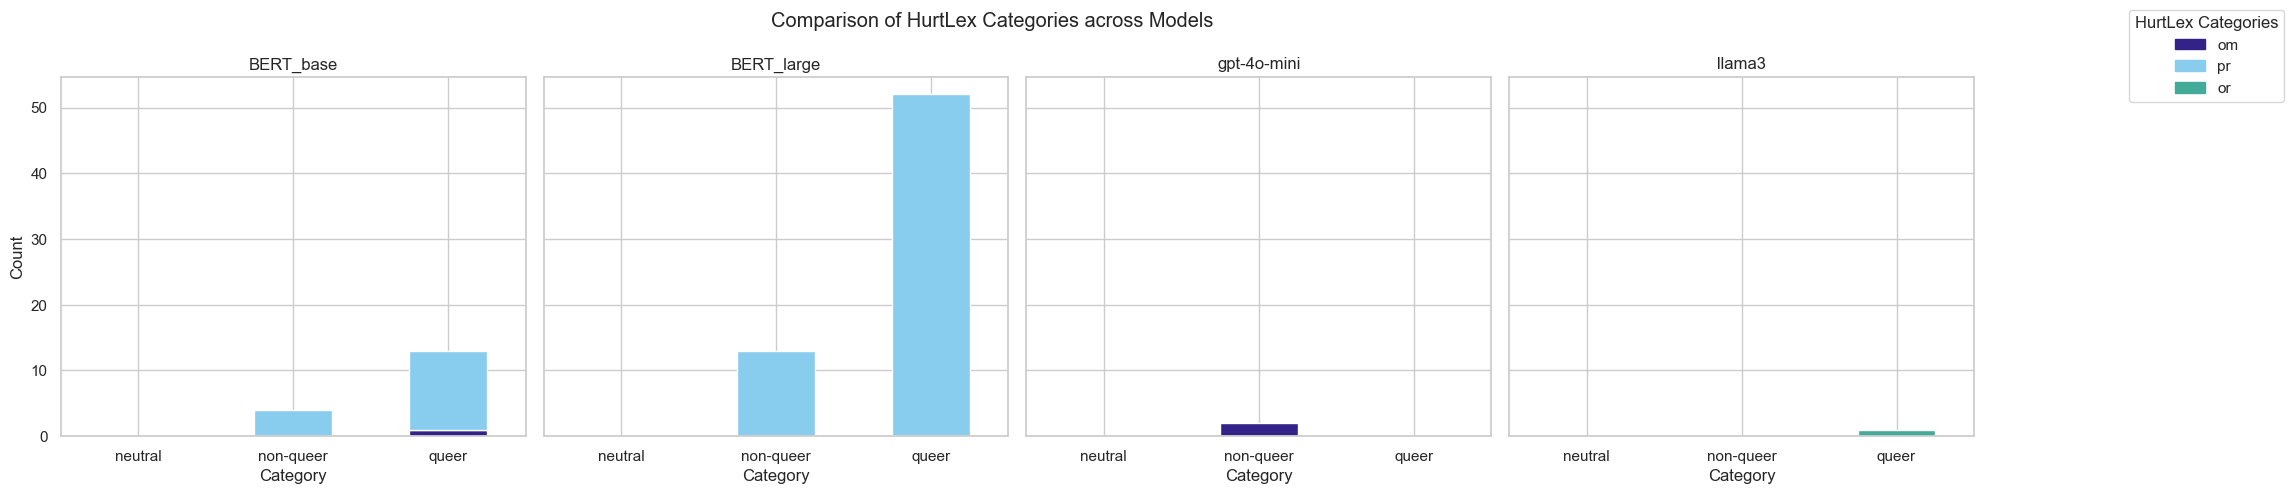

llama3 rejected (no valid categories)
gemma2 rejected (no valid categories)


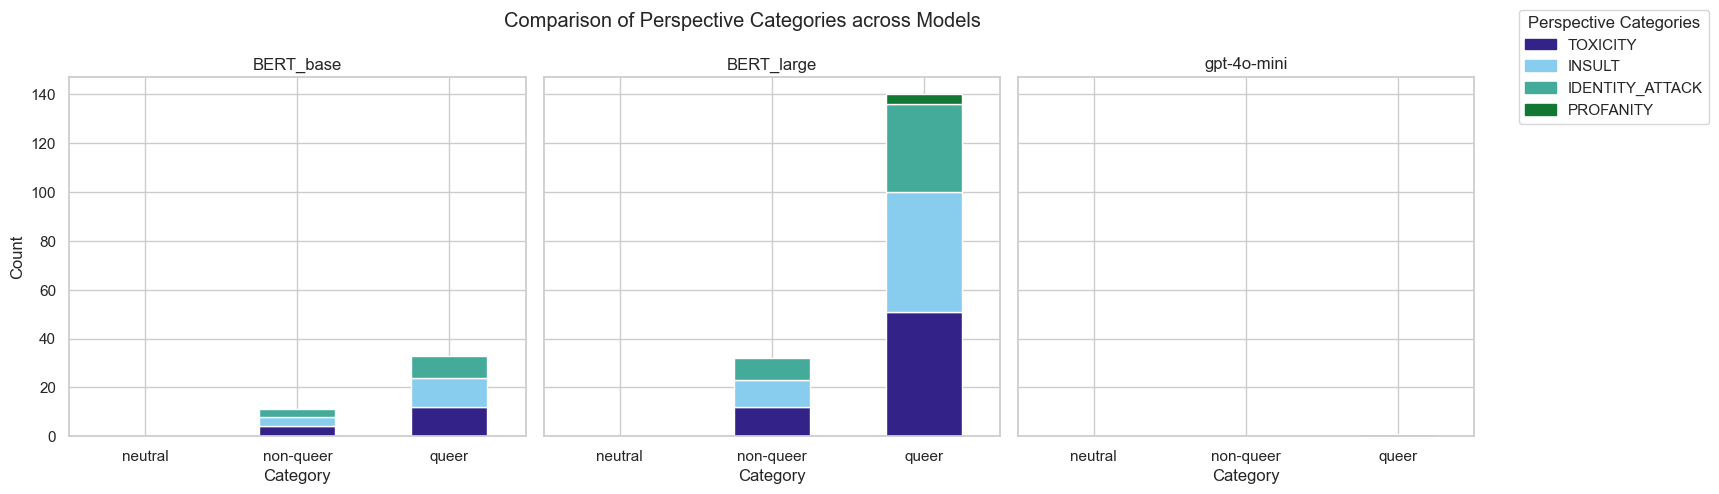

In [259]:
def stacked_bar_plot(models, tool):
    valid_models = []  # Keep track of models that have valid data
    valid_axes = []  # Track valid subplots
    totCategories = []  # Store all categories appearing in at least one model
    model_data = {}  # Store processed data to avoid reloading CSVs

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")

        # Initialize counts
        if tool == HURTLEX:
            for cat in HURTLEX_CATEGORIES_SHORT:
                df[HURTLEX + " " + cat] = 0

            for idx, row in df.iterrows():
                cat = row[HURTLEX]
                if str(cat) != "nan" and cat in HURTLEX_CATEGORIES_SHORT:
                    df.at[idx, HURTLEX + " " + cat] += 1

            mean_scores = df.groupby(TYPE)[[HURTLEX + " " + cat for cat in HURTLEX_CATEGORIES_SHORT]].sum()
        else:
            mean_scores = df.groupby(TYPE)[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]].sum()

        # Select nonzero categories
        nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

        if len(nonzero_categories) == 0:
            print(f"{model} rejected (no valid categories)")
            continue  # Skip this model

        # Add to valid models and store processed data
        valid_models.append(model)
        model_data[model] = mean_scores

        # Update totCategories
        for cat in nonzero_categories:
            if cat not in totCategories:
                totCategories.append(cat)

    if not valid_models:
        print("No models have valid data to plot.")
        return

    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(valid_models), figsize=(5 * len(valid_models), 5), sharey=True)
    if len(valid_models) == 1:
        axes = [axes]  # Ensure iterable when only one model

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(totCategories)}

    # Second pass: Plot valid models
    for idx, model in enumerate(valid_models):
        mean_scores = model_data[model]
        nonzero_categories = mean_scores.columns.intersection(totCategories)

        ax = axes[idx]  # Assign subplot
        valid_axes.append(ax)

        # Plot stacked bar chart with fixed colors
        mean_scores[nonzero_categories].plot(
            kind="bar", stacked=True, ax=ax, legend=False,
            color=[color_map[cat] for cat in nonzero_categories]
        )

        # Customize each subplot
        ax.set_title(model)
        ax.set_xlabel("Category")
        ax.tick_params( labelrotation=0)
        if idx == 0:
            ax.set_ylabel("Count")

    # Global settings
    plt.suptitle(f"Comparison of {tool} Categories across Models")

    # Single legend for all subplots
    legend_labels = [name.replace(tool + " ", "") for name in totCategories]
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in totCategories]

    plt.figlegend(legend_handles, legend_labels, title=f"{tool} Categories", loc="upper right", bbox_to_anchor=(1.15, 1))
    #plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example calls
stacked_bar_plot(MODELS, HURTLEX)
stacked_bar_plot(MODELS, PERSPECTIVE)

## Toxicity

In [ ]:
def toxicity_bar(models):
    valid_models = []  # Keep track of models that have valid data
    model_data = {}  # Store processed data to avoid reloading CSVs
    for i, model in enumerate(models):
        x = np.arange(len(NOUN_TYPES))  # X positions
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE)[[TOXICITY]].sum()
    
        # Select nonzero categories
        nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

        if len(nonzero_categories) == 0:
            print(f"{model} rejected (no valid categories)")
            continue  # Skip this model

        # Add to valid models and store processed data
        valid_models.append(model)
        model_data[model] = mean_scores


    if not valid_models:
        print("No models have valid data to plot.")
        return
    
    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(valid_models), figsize=(5 * len(valid_models), 5), sharey=True)
    if len(valid_models) == 1:
        axes = [axes]  # Ensure iterable when only one model

    # Second pass: Plot valid models
    for idx, model in enumerate(valid_models):
        mean_scores = model_data[model]
        ax = axes[i]
        bar_width = 0.15
        x = np.arange(len(NOUN_TYPES))  # X positions
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

#        mean_scores = df.groupby(TYPE)[[TOXICITY]].sum()
        
        values = mean_scores[TOXICITY].values
        ax.bar(x  * bar_width, values, bar_width, label=TOXICITY)
    
        ax.set_title(model)
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(NOUN_TYPES)
        ax.set_xlabel("Category")
        if i == 0:
            ax.set_ylabel("Score")
            
    #plt.xlabel("Subject Type")
    #plt.ylabel("Average Sentiment Score")
    plt.suptitle(f"Comparison of Sentiment Scores by Subject Type")
    plt.legend(title="Sentiment Analysis Tool")
    plt.tight_layout()
    #plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

toxicity_bar(MODELS)

BERT_base rejected (no valid categories)
BERT_large rejected (no valid categories)
gpt-4o-mini rejected (no valid categories)
llama3 rejected (no valid categories)
gemma2 rejected (no valid categories)
No models have valid data to plot.


# Lexical and Probabilistic Evaluation

# Perplexity Score

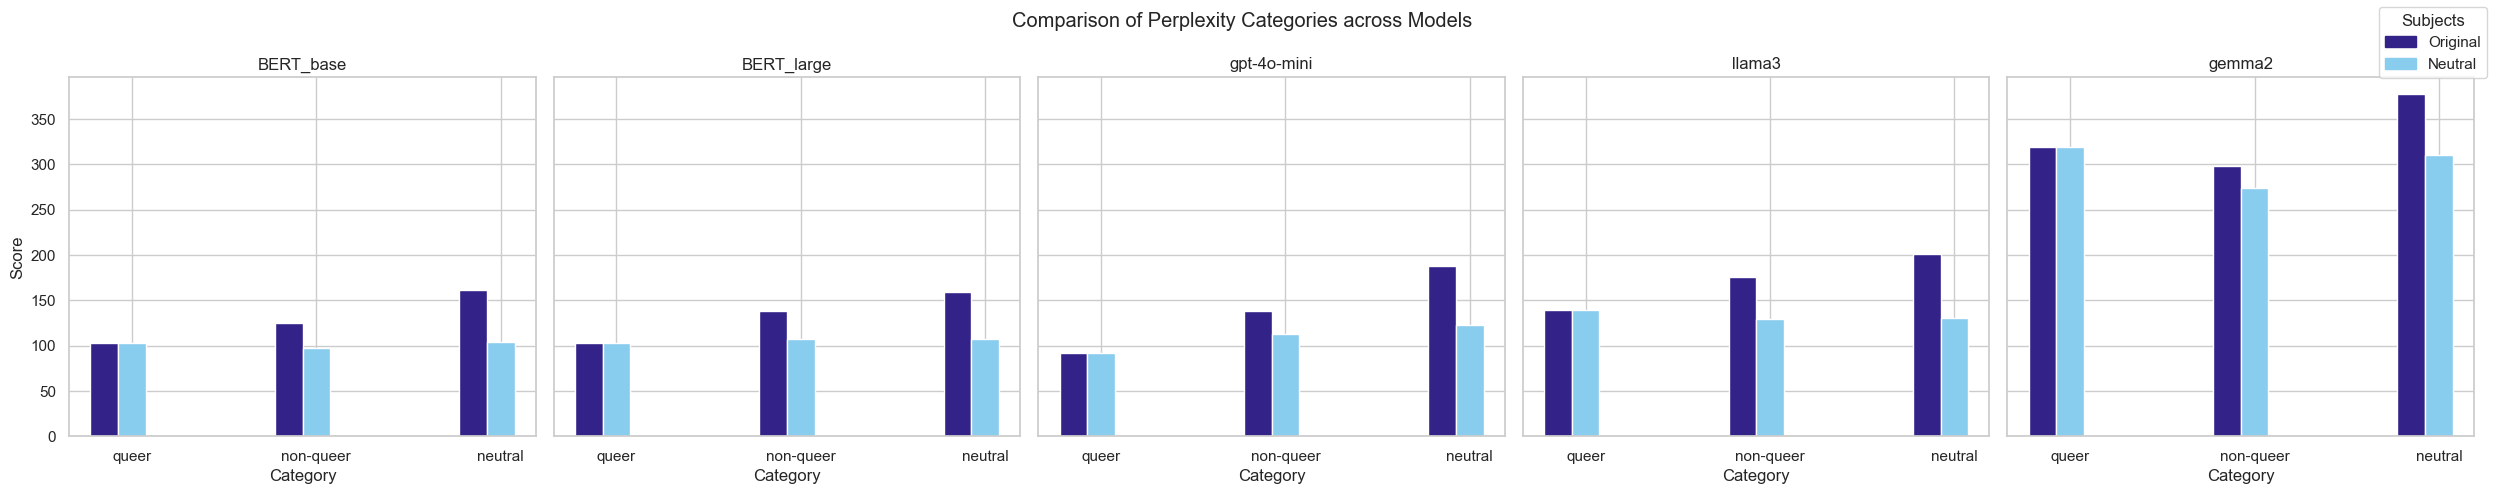

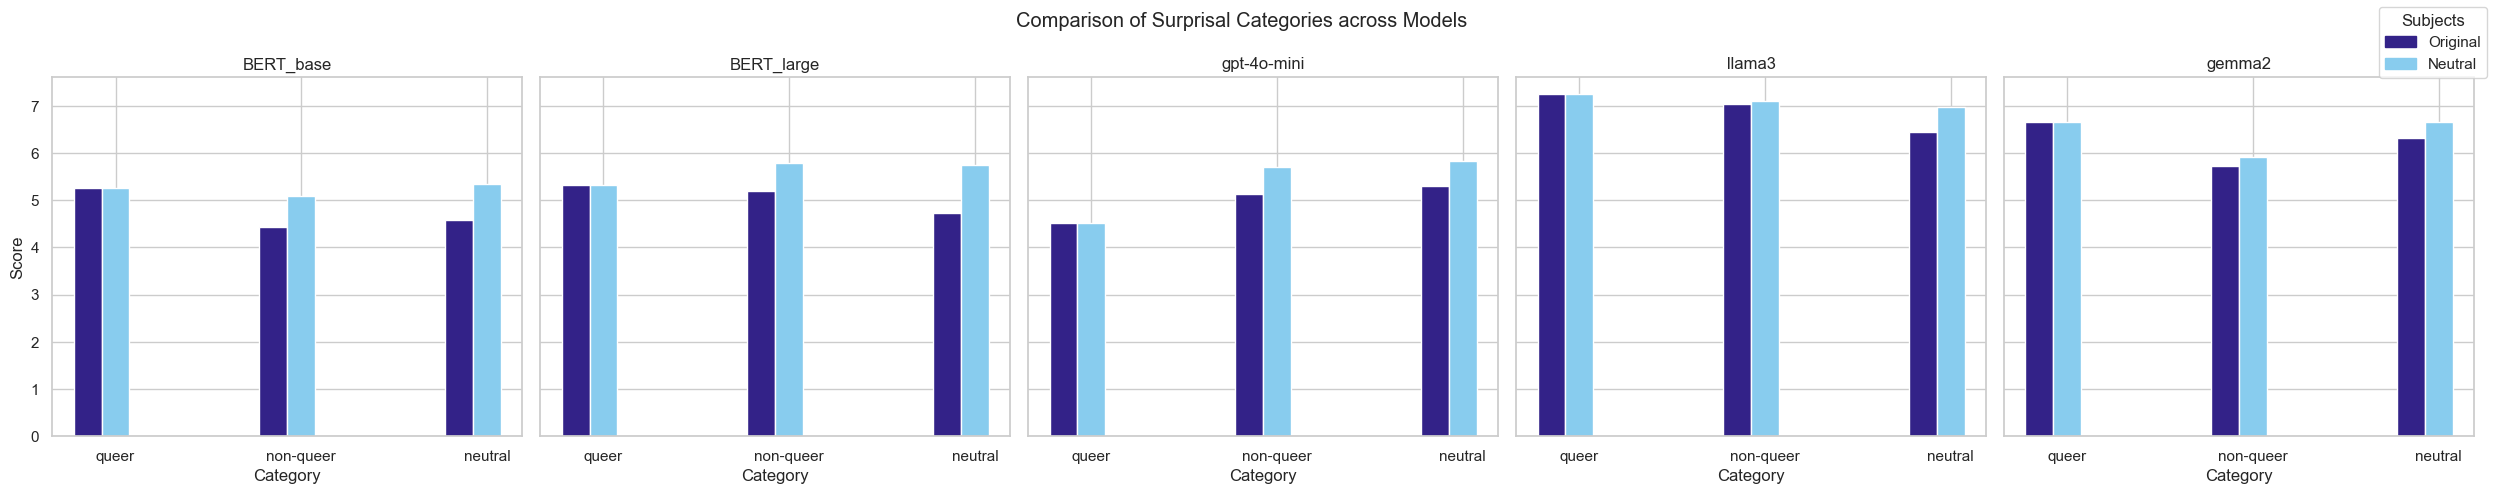

In [261]:
def perplexity_avg_values(models, evalMetric): 
    tools = [evalMetric, evalMetric+" (PERS)"]
    model_data = {}  # Store processed data to avoid reloading CSVs

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")
        model_data[model] = df.groupby("type")[[evalMetric, evalMetric+" (PERS)"]].mean().reset_index()

    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5), sharey=True)
    if len(models) == 1:
        axes = [axes]  # Ensure iterable when only one model

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(tools)}

    # Second pass: Plot valid models
    for idx, model in enumerate(models):
        #sns.set(style="whitegrid")
        mean_scores = model_data[model]
        ax = axes[idx]
        bar_width = 0.15
        x = np.arange(len(NOUN_TYPES))  # X positions
        
        for j, tool in enumerate(tools):
            values = mean_scores[tool].values
            ax.bar(x + j * bar_width, values, bar_width, label=tool, color=[color_map[tool]])
            ax.set_title(model)
            ax.set_xticks(x + bar_width)
            ax.set_xticklabels(NOUN_TYPES)
            ax.set_xlabel("Category")
            if idx == 0:
                ax.set_ylabel("Score")

    # Global settings
    plt.suptitle(f"Comparison of {evalMetric} Categories across Models")
    legend_labels = ["Original", "Neutral"]
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in tools]
    plt.figlegend(legend_handles, legend_labels, title = "Subjects")
    plt.tight_layout()
    plt.show()
    
perplexity_avg_values(MODELS, PERPLEXITY)
perplexity_avg_values(MODELS, SURPRISAL)


With the following graphs is not visibly clear the score gap in term of perplexity within the original subject type and the neutral one, plus, the graph appearence depends on the number of samples of a specific subject category 

In [262]:
def scatter_plot(model_name, subType, evalMetric):
    file_path = f"{OUTPUT_EVALUATION+model_name}.csv" # Update with the correct file path
    df = pd.read_csv(file_path)

    df_queer = df[df['type'] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100) / df_queer[evalMetric]
    df_queer[evalMetric+"_Diff ABS"] = abs(( df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100 / df_queer[evalMetric])
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    x = range(len(df_queer))  # X-axis as a sequence (since index is sorted by Perplexity)
    y = df_queer[evalMetric]
    y1 = df_queer[evalMetric+" (PERS)"]
    y2 = df_queer[evalMetric+"_Diff"]

    plt.figure(figsize=(10, 6))
    # Plot the lines
    plt.plot(x, y, label=evalMetric, linestyle="-")
    plt.plot(x, y1, label=evalMetric+" (PERS)", linestyle="dashed")
    #plt.plot(x, y2, label=evalMetric+"_Diff", linestyle="-.")
    plt.fill_between(x, y, y1, color="green", alpha=0.5)

    plt.xlabel("Sorted Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} based on the subject on {model_name}")
    plt.legend()
    plt.show()

# scatter_plot(MODEL_NAME, QUEER, PERPLEXITY)
# scatter_plot(MODEL_NAME, NONQUEER, PERPLEXITY)
# scatter_plot(MODEL_NAME, QUEER, SURPRISAL)
# scatter_plot(MODEL_NAME, NONQUEER, SURPRISAL)

In [263]:
def scatter_plot(model_name, subType, evalMetric):
    df = pd.read_csv(f"{OUTPUT_EVALUATION+BERT_LARGE}.csv")  # Replace 'your_data.csv' with the actual file path

    # Filter for only "queer" subject type
    df_queer = df[df["type"] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric]) * 100) / df_queer[evalMetric]

    # Sort by Perplexity_Diff
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Calculate the line of best fit
    x = range(len(df_queer))
    y1 = df_queer[evalMetric]
    y2 = df_queer[evalMetric+" (PERS)"]

    slope1, intercept1 = np.polyfit(x, y1, 1)
    line1 = slope1 * x + intercept1
    slope2, intercept2 = np.polyfit(x, y2, 1)
    line2 = slope2 * x + intercept2

    # Plot Perplexity scores
    plt.scatter(x, y1, color='blue', label="Original", alpha=0.6)
    plt.scatter(x, y2, color='red', label="Neutral", alpha=0.6)
    plt.plot(x, line1, color='lightblue')
    plt.plot(x, line2, color='orange')

    # Labels and title
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} on {subType} subject on {model_name}")
    plt.legend(["Original", "Neutral"], title="Subject type")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show plot
    plt.tight_layout()
    plt.show()
# scatter_plot(BERT_LARGE, QUEER, PERPLEXITY)
# scatter_plot(BERT_LARGE, NONQUEER, PERPLEXITY)
# scatter_plot(BERT_LARGE, QUEER, SURPRISAL)
# scatter_plot(BERT_LARGE, NONQUEER, SURPRISAL)


,Model,Diversity,Top 3
0,queer,0.15,"[god, translator, model]"
1,non-queer,0.43,"[teacher, bodyguard, doctor]"
2,neutral,0.80,"[farmer, driver, teacher]"


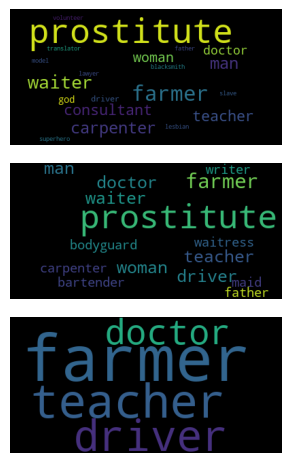

In [264]:
from wordcloud import WordCloud
from statistics import mode

def most_common(lst, num):
    topList = []
    m = ""
    for n in range(num):
        m = mode(lst)
        topList.append(m)
        lst = [l for l in lst if l !=m]
    return topList

def getDiversityScore(model_name, topWords):
    data = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv") 
    tab, images = [], []
    for subjCat in NOUN_TYPES:
        df = data[data['type'] == subjCat].copy()
        wordList = df[GENERATED].tolist()
        #print(f"The most common generated words: {most_common(wordList, topWords)}")

        textWords = ""
        for word in wordList:
            textWords = textWords + " "+ word    
        wordList = list(set(wordList))
        #print(f"Diversity score for {subjCat}: {round(len(wordList)/ len(df), 2)}")
        tab.append([subjCat, round(len(wordList)/ len(df), 2), most_common(wordList, 3)])
        images.append(WordCloud().generate(textWords))

    tab = pd.DataFrame(tab, columns=['Model', 'Diversity', f'Top {topWords}'])
    display(tab)
    
    f, axarr = plt.subplots(3,1) 
    for idx, img in enumerate(images):
        axarr[idx].imshow(img)
        axarr[idx].axis("off")
        axarr[idx].set_xticklabels([])
        axarr[idx].set_yticklabels([])
        axarr[idx].set_aspect('equal')
    f.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()
    
getDiversityScore(MODEL_NAME, 3)